In [1]:
# Basic Imports
import numpy as np
import pandas as pd
from scipy import stats
import pickle
import re
import collections
import tables as tb
from math import isnan
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
# Create folds for CV (default Stratified based on DX)
from sklearn import preprocessing
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import KFold
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

/projects/nikhil/ADNI_prediction/code/conda_envs/adni-conda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
/projects/nikhil/ADNI_prediction/code/conda_envs/adni-conda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
#Data imports
baseline_dir = '/projects/nikhil/FEP_Carolina/'
MAGeT_SA_dir = baseline_dir + 'MAGeT_surface_area_smoothed/'
FSL_SA_dir = baseline_dir + 'FSL_surface_area_smoothed/'

FSL_structure_list = ['Dx','L_Thal','R_Thal','L_Pall','R_Pall','L_Caud','R_Caud','L_Accu','R_Accu','L_Puta','R_Puta']
MAGeT_structure_list = ['Dx','thalamus_left','thalamus_right','striatum_left','striatum_right','gp_left','gp_right']

In [3]:
#read txt files for each subject and structure and store it in the dataframe
def generate_df(dir_path, structure_list):
    file_list = glob.glob(dir_path)    
    df = pd.DataFrame(columns=structure_list)
    #iterate through all the files
    for f,file_path in enumerate(file_list):
        file_name = os.path.basename(file_path)
        subID = file_name.split('_')[2]
        Dx = file_name.split('_')[1]        
        df.set_value(subID, 'Dx', Dx)
        
        for struct in structure_list:
            match = struct in file_name            
            if match:
                data = np.squeeze(pd.read_csv(file_path,header=None).values)
                df.set_value(subID, struct, data)
    return df

def generate_data_arrays(df,feature_list):
    feat_idx_dict = {} #start and end indices of each structure vertices in the concatinated array
    start_idx = 0
    for f, struct in enumerate(feature_list):        
        feat_arr = np.vstack(np.array(df[struct].values))
        feat_idx_dict[struct]=(start_idx, start_idx + feat_arr.shape[1])
        start_idx += feat_arr.shape[1]
        
        if f==0:
            X = feat_arr
        else:
            X = np.hstack((X,feat_arr))
    
    y =  df['Dx'].values
    return {'X':X, 'y':y, 'feat_idx_dict':feat_idx_dict}

def pickleIt(my_data,save_path):
    f = open(save_path, 'wb')
    pickle.dump(my_data, f)
    f.close()
    
#Outer Fold Computation (need the imports inside def if you want to parallelize!)
def computeOuterFold(train_X, train_y, valid_X, valid_y, model_clf, hyper_params, output_type, model_type):    
    import collections
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Lasso
    from sklearn.svm import SVR
    from sklearn.ensemble import RandomForestRegressor
    from sklearn import grid_search
    import datetime
    import time
    import collections
    from scipy.stats import mode
    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae
    from scipy import stats
    import numpy as np
    
    print 'Starting Outerfold computation'
    
    hp_dict = collections.defaultdict(list) #store best hyper-parameters for each fold
    inner_loop = True
    if inner_loop:     
        print 'Starting InnerFold computation'        
        clf = innerCVLoop(model_clf,hyper_params,train_X, train_y)
        for hp in hyper_params:
            hp_dict[hp].append(clf.best_estimator_.get_params()[hp])
            
        print 'Ending InnerFold computation'

    else:
        clf = model_clf
        clf.fit(fold_X,fold_y)
    
    if output_type == 'regression':
        #CV_scores    
        r_train = stats.pearsonr(clf.predict(train_X),train_y)
        r_valid = stats.pearsonr(clf.predict(valid_X),valid_y)

        R2_train = clf.score(train_X,train_y) 
        R2_valid = clf.score(valid_X,valid_y)

        MSE_train = mse(clf.predict(train_X),train_y)
        MSE_valid = mse(clf.predict(valid_X),valid_y)

        MAE_train = mae(clf.predict(train_X),train_y)
        MAE_valid = mae(clf.predict(valid_X),valid_y)
        
        return_dict = {'r_train':r_train, 'r_valid':r_valid, 'R2_train':R2_train, 'R2_valid':R2_valid,
            'MSE_train':MSE_train, 'MSE_valid':MSE_valid, 'MAE_train':MAE_train, 'MAE_valid':MAE_valid,
            'hp_dict':hp_dict, 'predicted_fold_score': clf.predict(valid_X), 'actual_fold_scores':valid_y}
        
    elif output_type == 'classify':
        pred_y = clf.predict(valid_X) #Specific label value
        pred_y_prob = clf.predict_proba(valid_X) #Label probabilty (used for ROC)

        #feature imp (issue with the innerCVLoop)
        if model_type == 'RFC':
            feat_imp = clf.best_estimator_.feature_importances_
        elif model_type == 'LR_L1':
            feat_imp = clf.best_estimator_.coef_ 
        else: 
            print "Unknown model for computing feature importance. Setting it to zeros"
            feat_imp = np.zeros(len(pred_y))

        print 'Ending OuterFold computation'

        return_dict = {'actual_fold_scores':valid_y, 'predicted_fold_prob':pred_y_prob, 'predicted_fold_score': pred_y, 
                'hp_dict':hp_dict, 'feat_imp': feat_imp}
    
    else: 
        print 'unknown output_type'

    print 'Ending OuterFold computation'
    
    return return_dict

#Inner Fold Computation (need the imports inside def if you want to parallelize!)
def innerCVLoop(model_clf,hyper_params,fold_X, fold_y):
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Lasso
    from sklearn.svm import SVR
    from sklearn.ensemble import RandomForestRegressor
    from sklearn import grid_search
    clf = grid_search.GridSearchCV(model_clf, hyper_params,cv=3,verbose=0)
    clf.fit(fold_X, fold_y)   
    return clf

In [ ]:
# import data into dataframes
df_FSL_HC = generate_df(FSL_SA_dir + 'HC/*', FSL_structure_list[1:])
df_MAGeT_HC = generate_df(MAGeT_SA_dir + 'HC/*', MAGeT_structure_list[1:])
df_FSL_FEP = generate_df(FSL_SA_dir + 'FEP/*', FSL_structure_list[1:])
df_MAGeT_FEP = generate_df(MAGeT_SA_dir + 'FEP/*', MAGeT_structure_list[1:])

In [ ]:
#some sanity checks w.r.t. sample size and dimensions
print len(df_FSL_HC),len(df_MAGeT_HC),len(df_FSL_FEP),len(df_MAGeT_FEP)

for struct in MAGeT_structure_list[1:]:
    vert_numx = len(df_MAGeT_HC[struct][0])
    print '{}: {}'.format(struct,vert_numx)

In [ ]:
#concat all the structures and generate k-folds 
#we will separate structures later to maintain correspondance between subjects for each structure. 

#generate X,y arrays
FSL_HC_results = generate_data_arrays(df_FSL_HC,FSL_structure_list[1:])
FSL_FEP_results = generate_data_arrays(df_FSL_FEP,FSL_structure_list[1:])
MAGeT_HC_results = generate_data_arrays(df_MAGeT_HC,MAGeT_structure_list[1:])
MAGeT_FEP_results = generate_data_arrays(df_MAGeT_FEP,MAGeT_structure_list[1:])

FSL_X = np.vstack((FSL_HC_results['X'],FSL_FEP_results['X']))
MAGeT_X = np.vstack((MAGeT_HC_results['X'],MAGeT_FEP_results['X']))
FSL_feat_idx_dict = FSL_HC_results['feat_idx_dict']
MAGeT_feat_idx_dict = MAGeT_HC_results['feat_idx_dict']
y_dx = np.concatenate((FSL_HC_results['y'],FSL_FEP_results['y'])) #same as MAGeT y

#Generate K-folds
le = preprocessing.LabelEncoder()
le.fit(y_dx)
y = le.transform(y_dx) 

kf = StratifiedKFold(y, n_folds=10)

In [43]:
# exp_name = 'CV_FSL'
# exp_setup_path = baseline_dir + 'exp_data/{}.pkl'.format(exp_name)
# exp_setup = pickle.load( open(exp_setup_path, "rb" ) )
# feat_idx_dict = exp_setup['feat_idx_dict']

# feat_idx_dict

# # caudate, putamen, and accumbens
# # 2254 = 3538-2568+6532-5890+5248-4606

2254

In [ ]:
save_experimental_setup = False #Saves X, y, and KF

exp_name = 'FSL'
if exp_name == 'MAGeT':
    X = MAGeT_X #either FSL_X or MAGeT_X
    feat_idx_dict = MAGeT_feat_idx_dict
elif exp_name == 'FSL':
    X = FSL_X #either FSL_X or MAGeT_X
    feat_idx_dict = FSL_feat_idx_dict
else:
    print 'unknown exp_name'

for train_index, test_index in kf:    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #print 'DX distribution: {}'.format((np.sum(y[test_index]==0),np.sum(y[test_index]==1)))
    #print 'y_train_mean: {}, y_test_mean: {}'.format(np.mean(y_train),np.mean(y_test))
    
save_path = baseline_dir + 'exp_data/CV_{}.pkl'.format(exp_name)    
print 'Saving exp_setup to: {}'.format(save_path)
if save_experimental_setup:    
    exp_setup = {'X': X, 'y': y, 'kf':kf ,'feat_idx_dict':feat_idx_dict,'exp_name':exp_name}    
    pickleIt(exp_setup, save_path)        

In [4]:
# Configs for K-fold validations (nested)
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import grid_search
import datetime
import time
import collections
from scipy.stats import mode
from sklearn.metrics import mean_squared_error as mse
from functools import partial #Parallelize!!! 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from scipy import interp
from sklearn.metrics import accuracy_score as acc
import ipyparallel as ipp
from sklearn import preprocessing
from sklearn.cross_validation import KFold
import pickle
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN #For treating class imbalance
from sklearn.decomposition import PCA

In [5]:
#Pick model with its configs/hyper-paramsd
def getModel(model_choice,output_type): 
    if output_type == 'regression' :
        if model_choice == 'LR_L1':
            model_clf = Lasso()
            hyper_params = {'alpha':[0.1, 0.05, 0.01]} 
            scale_data = True 
            feat_imp = False   

        elif model_choice == 'SVR':
            model_clf = SVR()
            hyper_params = {'kernel':['linear','rbf'], 'C':[1,10,25]}
            scale_data = True 
            feat_imp = False

        elif model_choice == 'RFR':
            model_clf = RandomForestRegressor(n_jobs=4)
            hyper_params = {'n_estimators':[10,50,100,200],'min_samples_split':[2,4,8]}    
            scale_data = True    
            feat_imp = False   
        else:
            print "Unknown model choice"
    
    elif output_type =='classify':
        if model_choice == 'LR_L1':
            model_clf = LogisticRegression(penalty='l1',n_jobs=4,class_weight='balanced')
            hyper_params = {'C':[0.01,.1,1,10]} 
            scale_data = True #Scales features (z-score)            
            feat_imp = False #The learned weights of each variable

        elif model_choice == 'SVC':
            model_clf = SVC(class_weight='balanced',probability=True)
            hyper_params = {'kernel':['linear','rbf'], 'C':[1,10]}
            scale_data = True #Scales HC and CT features            
            feat_imp = False

        elif model_choice == 'RFC':    
            model_clf = RandomForestClassifier(n_jobs=4,class_weight='balanced' )
            hyper_params = {'n_estimators':[10,25,50],'min_samples_split':[2,4,8]}    
            scale_data = True            
            feat_imp = True   #RF oob based feature importance

        else:
            print "Unknown model choice"
    
    else: 
        print 'Unknown output type'

    return {'model_clf':model_clf,'hyper_params':hyper_params,'scale_data':scale_data,'feat_imp':feat_imp}

def apply_PCA(X_train,X_valid,pc_numx):
    pca = PCA(n_components=pc_numx)
    pca.fit(X_train)
    total_explained_var_ratio = np.sum(pca.explained_variance_ratio_)
    return {'X_train_redux':pca.transform(X_train),'X_valid_redux':pca.transform(X_valid),
            'explained_var_ratio':total_explained_var_ratio}
    

In [7]:
# Train and Test models
from functools import partial #Parallelize!!! 

# Load saved experimental setup
exp_name = 'CV_MAGeT'
exp_setup_path = baseline_dir + 'exp_data/{}.pkl'.format(exp_name)
exp_setup = pickle.load( open(exp_setup_path, "rb" ) )
X_raw = exp_setup['X']
y = exp_setup['y']
kf = exp_setup['kf']
feat_idx_dict = exp_setup['feat_idx_dict']

# resample imblanced data
resample_train_data = False
sampling_tech = 'smote'

# dim_redux
use_PCA = True
pc_numx_list = [10,50,100] # FSL:50, MAGeT:100 (99%variance)

# Parallization configs for ipython notebook cluster    
rc = ipp.Client()
dview = rc[:]
dview.push(dict(computeOuterFold = computeOuterFold))
dview.push(dict(innerCVLoop = innerCVLoop))

save_CV_perf = True
plot_ROC = False
perf_metrics = ['exp_name','structure','model','fold','actual_labels','predicted_labels','accuracy','confusion_matrix']
perf_df = pd.DataFrame(columns=perf_metrics)

##########################################
## Select input modalities (structures) ##
########################################## 
#striatum (for FSL we should collapse the measures across caudate, putamen, and accumbens)
if exp_name == 'CV_FSL':    
    structure_list = ['L_Thal','R_Thal','L_Pall','R_Pall','L_Stri','R_Stri','ALL']
elif exp_name == 'CV_MAGeT':
    structure_list = ['thalamus_left','thalamus_right','striatum_left','striatum_right','gp_left','gp_right','ALL']
else:
    print 'unknow exp_name'

for pc_numx in pc_numx_list:
    for structure in structure_list:
        if structure == 'ALL':
            X_modality = X_raw
        elif structure == 'L_Stri':        
            X_caud = X_raw[:,feat_idx_dict['L_Caud'][0]:feat_idx_dict['L_Caud'][1]]
            X_puta = X_raw[:,feat_idx_dict['L_Puta'][0]:feat_idx_dict['L_Puta'][1]]
            X_accu = X_raw[:,feat_idx_dict['L_Accu'][0]:feat_idx_dict['L_Accu'][1]]
            X_modality = np.hstack((X_caud, X_puta, X_accu))
        elif structure == 'R_Stri':
            X_caud = X_raw[:,feat_idx_dict['R_Caud'][0]:feat_idx_dict['R_Caud'][1]]
            X_puta = X_raw[:,feat_idx_dict['R_Puta'][0]:feat_idx_dict['R_Puta'][1]]
            X_accu = X_raw[:,feat_idx_dict['R_Accu'][0]:feat_idx_dict['R_Accu'][1]]
            X_modality = np.hstack((X_caud, X_puta, X_accu))        
        else:        
            start_idx = feat_idx_dict[structure][0]
            end_idx = feat_idx_dict[structure][1]
            X_modality = X_raw[:,start_idx:end_idx]

        print 'using strucutre: {}, with shape: {}'.format(structure,X_modality.shape)
        scale_data = True #since we are using PCA
        if scale_data:
            X = preprocessing.scale(X_modality)
        else:
            X = X_modality

        # Create list of all the fold-subsets (needed for parallelization)
        X_train = []
        X_valid = []
        y_train = []
        y_valid = []    
        for train, valid in kf:
            if resample_train_data:             
                #resample with tools from: https://github.com/scikit-learn-contrib/imbalanced-learn
                if sampling_tech == 'adasyn':                    
                    resamp_tech = ADASYN()
                elif sampling_tech == 'smote':
                    resamp_tech = SMOTE(kind='regular')
                else:
                    resamp_tech = RandomOverSampler()

                print 'using {} oversampling technique'.format(sampling_tech)                    
                X_resampled, y_resampled = resamp_tech.fit_sample(X[train], y[train])
                #print 'Original shapes: X{}, y:{}, y==1: {}'.format(X[train].shape, y[train].shape, np.sum(y[train]))
                #print 'Resampled shapes: X{}, y:{}, y==1: {}'.format(X_resampled.shape, y_resampled.shape, np.sum(y_resampled))                

            else:
                X_resampled = X[train]
                y_resampled = y[train]

            if not use_PCA:        
                X_train_redux = X_resampled
                X_valid_redux = X[valid]   # No need to resample test data        

            else:
                #print 'Using PCA for each fold'
                dim_redux_result = apply_PCA(X_resampled,X[valid],pc_numx)
                X_train_redux = dim_redux_result['X_train_redux']
                X_valid_redux = dim_redux_result['X_valid_redux']    
                total_explained_var_ratio = dim_redux_result['explained_var_ratio']

            X_train.append(X_train_redux)                
            X_valid.append(X_valid_redux)

            y_train.append(y_resampled)
            y_valid.append(y[valid])

#             print 'X_train: {}, y_train: {}, X_valid: {}, y_valid: {}, total_explained_var: {}'.format(X_train_redux.shape, 
#                                                                                                        X_valid_redux.shape,
#                                                                                                        y_resampled.shape,
#                                                                                                        y[valid].shape,
#                                                                                                       total_explained_var_ratio)

        ####################
        ## Select a model ##
        ####################        

        # Task type
        output_type = 'classify' #needs to be either 'classify' or 'regression'
        model_list = ['LR_L1','SVC','RFC']

        for model_choice in model_list:
            model_def = getModel(model_choice,output_type)
            model_clf = model_def['model_clf']
            hyper_params = model_def['hyper_params']    
            feat_imp = model_def['feat_imp']

            print 'structure: {}, model: {}, X shape {}'.format(structure, model_choice, X.shape)
            #Some paths to store models and performance stats
            CV_model_dir = baseline_dir + 'output/'
            save_model_path = CV_model_dir + exp_name + '_' + model_choice + '_' + structure
            save_model = False 

            # Compute various statistics on the predicted results acorss 10 Folds            
            CV_Acc_valid=[] #Acuracy
            CV_CM_valid=[] #Confusion matrix
            CV_AUC_valid=[] #ROC and AUC       
            CV_fpr_tpr = []
            CV_fpr_tpr_thrsh = []
            CV_feat_imp = []

            predicted_CV_scores = []
            actual_CV_scores = []

            #Parallelize k-folds
            mapfunc = partial(computeOuterFold, model_clf=model_clf, hyper_params=hyper_params, output_type=output_type, model_type=model_choice)
            parallel_result = dview.map_sync(mapfunc, X_train, y_train, X_valid, y_valid)    

            hp_dict = collections.defaultdict(list)
            for p, pr in enumerate(parallel_result):                             
                y_pred_score = pr['predicted_fold_score']
                y_pred_prob = pr['predicted_fold_prob']
                y_act = pr['actual_fold_scores']
                predicted_CV_scores.append(y_pred_score)
                actual_CV_scores.append(y_act)        

                #Acc    
                CV_Acc_valid.append(acc(y_pred_score,y_act))                

                #Roc - Auc
                fpr, tpr, thresholds = roc_curve(y_act, y_pred_prob[:,1]) 
                CV_fpr_tpr.append((fpr,tpr))        
                CV_fpr_tpr_thrsh.append(thresholds)
                roc_auc = roc_auc_score(y_act, y_pred_prob[:,1])
                CV_AUC_valid.append(roc_auc)

                #confusion matrix
                cm = confusion_matrix(y_pred_score,y_act)
                cm_normalized = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
                CV_CM_valid.append(cm_normalized)

                #performance dataframe
                single_perf_dict = [{'exp_name':exp_name,'pc_numx':pc_numx,'structure':structure,'model':model_choice,'fold':p+1,
                                     'actual_labels':y_act,'predicted_labels':y_pred_score,'predicted_labels_prob':y_pred_prob,
                                     'accuracy':acc(y_pred_score,y_act),'AUC':roc_auc,'confusion_matrix':cm_normalized}]

                perf_df = perf_df.append(single_perf_dict, ignore_index=True)

                for hp in hyper_params:
                    hp_dict[hp].append(pr['hp_dict'][hp])

            #Find out most frequent hyper-params during cross-val    
            hp_mode = {}
            for hp in hyper_params:
                hp_mode[hp] = mode(hp_dict[hp])[0][0]


            print 'most frequent hyper-params:' + str(hp_mode)
            print 'CV Acc (mean, std_err): {:04.2f}, {:04.2f}'.format(np.mean(CV_Acc_valid),stats.sem(CV_Acc_valid))
            print 'CV AUC (mean, std_err): {:04.2f}, {:04.2f}'.format(np.mean(CV_AUC_valid),stats.sem(CV_AUC_valid))
            print 'CV Confusion Matrix (mean): {}'.format(np.mean(np.array(CV_CM_valid),axis=0))
            print ''

            ##########ROC Plots##############       
            if plot_ROC:
                plot_name = 'ROC'

                print 'plotting :{}'.format(plot_name)
                print ''
                print ''
                mean_tpr = 0.0
                mean_fpr = np.linspace(0, 1, 100)
                all_tpr = []

                for i, (fpr, tpr) in enumerate(CV_fpr_tpr):                
                    mean_tpr += interp(mean_fpr, fpr, tpr)
                    mean_tpr[0] = 0.0
                    roc_auc = auc(fpr, tpr)
                    #plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

                mean_tpr /= len(CV_fpr_tpr)
                mean_tpr[-1] = 1.0
                mean_auc = auc(mean_fpr, mean_tpr)

                plt.plot(mean_fpr, mean_tpr, label='structure:{}, Model:{}, mean ROC (area = {:3.2f})'.format(structure, model_choice, mean_auc), lw=2)

                plt.xlim([-0.05, 1.05])
                plt.ylim([-0.05, 1.05])
                plt.xlabel('False Positive Rate',fontsize = 24)
                plt.ylabel('True Positive Rate',fontsize = 24)
                plt.title('Receiver operating characteristic',fontsize = 30)
                plt.legend(loc="lower right",fontsize = 12)


    #plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

if save_CV_perf:
    save_path = baseline_dir + 'exp_data/{}_perf_df.pkl'.format(exp_name)    
    print 'Saving exp_setup to: {}'.format(save_path)    
    pickleIt(perf_df, save_path)        

KeyboardInterrupt: 

In [6]:
perf_df[perf_df.ex]

NameError: name 'perf_df' is not defined

/projects/nikhil/ADNI_prediction/code/conda_envs/adni-conda/lib/python2.7/site-packages/pandas/core/internals.py:4352: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = op(a, b)
/projects/nikhil/ADNI_prediction/code/conda_envs/adni-conda/lib/python2.7/site-packages/pandas/core/missing.py:38: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x
/projects/nikhil/ADNI_prediction/code/conda_envs/adni-conda/lib/python2.7/site-packages/seaborn/categorical.py:3304: UserWarning: The `x_order` parameter has been renamed `order`
  UserWarning)


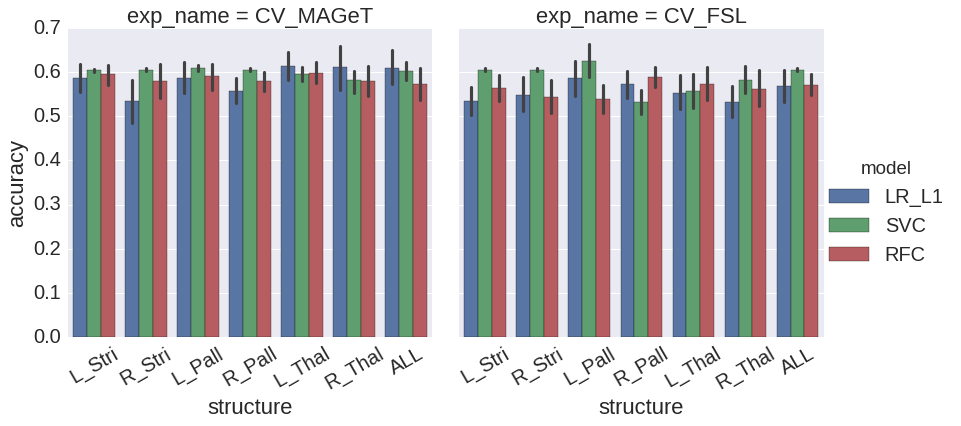

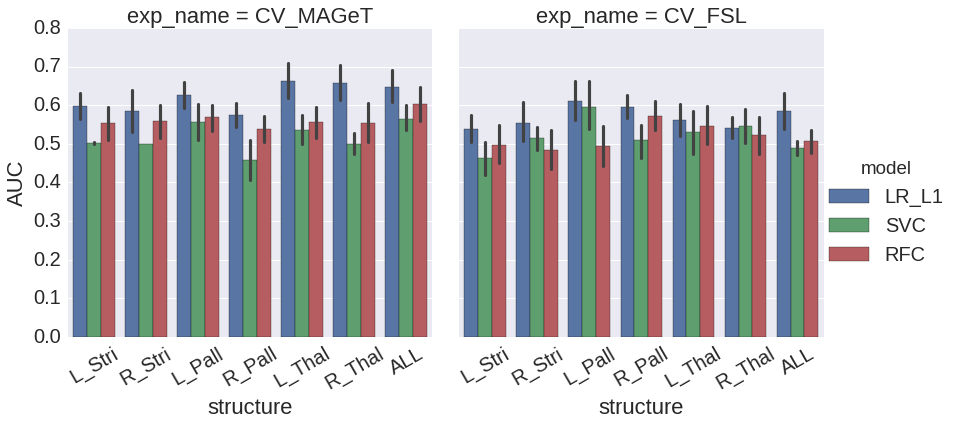

In [8]:
#Perf plots
save_figure = False
MAGeT_perf = pickle.load( open(baseline_dir + 'exp_data/CV_MAGeT_perf_df.pkl') )
FSL_perf = pickle.load( open(baseline_dir + 'exp_data/CV_FSL_perf_df.pkl') )

df_concat = MAGeT_perf.append(FSL_perf)

#change structure string labels to make them consistent across experiments. 
df_concat.replace({'thalamus_left':'L_Thal', 'thalamus_right':'R_Thal','gp_left':'L_Pall', 'gp_right':'R_Pall',
                         'striatum_left':'L_Stri', 'striatum_right':'R_Stri'}, inplace=True)

x_order = ['L_Stri','R_Stri','L_Pall','R_Pall','L_Thal','R_Thal','ALL']
sns.set(font_scale=2)
g = sns.factorplot(x="structure", y="accuracy", hue="model", kind="bar", col='exp_name', x_order=x_order,
                   size=6, sharey=True, data=df_concat)
g.set_xticklabels(rotation=30)

g = sns.factorplot(x="structure", y="AUC", hue="model", kind="bar", col='exp_name',  x_order=x_order,
                   size=6, sharey=True, data=df_concat)
g.set_xticklabels(rotation=30)

if save_figure:
    fig_name = 'FEP_perf_AUC.eps'
    g.savefig(baseline_dir + fig_name, format='eps', dpi=1000) 
    print 'saving fig at: {}'.format(baseline_dir + fig_name)

In [13]:
for exp_name in ['CV_MAGeT','CV_FSL']:
    print ''
    print 'exp_name: {}'.format(exp_name)
    for model in ['LR_L1', 'SVC', 'RFC']:
        print 'model: {}'.format(model)
        for struct in ['L_Thal','R_Thal','L_Pall','R_Pall','L_Stri','R_Stri','ALL']:
            acc = df_concat[(df_concat.exp_name==exp_name)&(df_concat.model==model)&(df_concat.structure==struct)]['accuracy'].values
            auc = df_concat[(df_concat.exp_name==exp_name)&(df_concat.model==model)&(df_concat.structure==struct)]['AUC'].values
            CM = df_concat[(df_concat.exp_name==exp_name)&(df_concat.model==model)&(df_concat.structure==struct)]['confusion_matrix'].values            
            print 'structure: {}, Accuracy: {:4.2f},{:4.2f}, AUC: {:4.2f},{:4.2f}'.format(struct, np.mean(acc), np.std(acc), np.mean(auc), np.std(auc))


exp_name: CV_MAGeT
model: LR_L1
structure: L_Thal, Accuracy: 0.61,0.09, AUC: 0.66,0.13
structure: R_Thal, Accuracy: 0.61,0.14, AUC: 0.66,0.13
structure: L_Pall, Accuracy: 0.59,0.10, AUC: 0.63,0.09
structure: R_Pall, Accuracy: 0.56,0.08, AUC: 0.57,0.09
structure: L_Stri, Accuracy: 0.59,0.09, AUC: 0.60,0.10
structure: R_Stri, Accuracy: 0.54,0.14, AUC: 0.59,0.15
structure: ALL, Accuracy: 0.61,0.11, AUC: 0.65,0.12
model: SVC
structure: L_Thal, Accuracy: 0.60,0.04, AUC: 0.54,0.10
structure: R_Thal, Accuracy: 0.58,0.08, AUC: 0.50,0.08
structure: L_Pall, Accuracy: 0.61,0.02, AUC: 0.56,0.12
structure: R_Pall, Accuracy: 0.61,0.01, AUC: 0.46,0.15
structure: L_Stri, Accuracy: 0.60,0.01, AUC: 0.50,0.01
structure: R_Stri, Accuracy: 0.61,0.01, AUC: 0.50,0.00
structure: ALL, Accuracy: 0.60,0.06, AUC: 0.56,0.10
model: RFC
structure: L_Thal, Accuracy: 0.60,0.07, AUC: 0.56,0.11
structure: R_Thal, Accuracy: 0.58,0.10, AUC: 0.55,0.14
structure: L_Pall, Accuracy: 0.59,0.08, AUC: 0.57,0.10
structure: R_Pal

In [11]:
df_concat.to_csv(baseline_dir+'FEP_perf.csv')

In [14]:
pickleIt(df_concat,baseline_dir+'FEP_perf.pkl')